### Central Question - Unsupervised Learning: What attributes should a property contain for it to be most financially viable for a housing company to sell ?

In [9]:
#importing the required packages 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [10]:
housing_data_clean = pd.read_csv(r'C:\Users\buoci\OneDrive\Desktop\Housing_data_Clean_for_testing.csv')

#importing the dataset

After importing the data, I will first remove the columns which are not important for k-means clustering of the housing properties.

In [11]:
housing_data_clean = housing_data_clean.drop(['Publication_Date'],axis=1)

#dropping publication date as it is not an important variable for clustering

In [12]:
housing_data_clean = housing_data_clean.drop(['globalId.1'],axis=1)

#dropping globalId as it is not an important variable for clustering

In [13]:
housing_data_clean = housing_data_clean.drop(['date_of_signage'],axis=1)

#dropping date of signage as it is not an important variable for clustering

In [14]:
housing_data_clean #displaying the dataframe to confirm the above operations

,Purchase_Price,soortWoning,categorieObject,Construction_Year,Garden,Number_of_rooms,Energy_label,inside_surface_size
0,139000.0,<{woonboot}> <{vrijstaande woning}>,House,1975.0,1,3,C,62
1,209000.0,<{eengezinswoning}> <{tussenwoning}>,House,1980.0,1,5,B,136
2,267500.0,<{tussenverdieping}> (<{appartement}>),Apartment,2005.0,0,3,C,70
3,349000.0,<{eengezinswoning}> <{geschakelde 2-onder-1-ka...,House,1973.0,1,5,C,144
4,162500.0,<{eengezinswoning}> <{hoekwoning}>,House,1970.0,1,4,C,68
...,...,...,...,...,...,...,...,...
158637,227500.0,<{eengezinswoning}> <{tussenwoning}>,House,2012.0,1,4,A,131
158638,159000.0,<{eengezinswoning}> <{tussenwoning}>,House,1974.0,1,5,C,116
158639,179000.0,<{eengezinswoning}> <{geschakelde 2-onder-1-ka...,House,1995.0,1,4,C,84
158640,391500.0,<{bungalow}> <{vrijstaande woning}> (<{semi-bu...,House,1948.0,1,5,C,99


In [15]:
import re

#creating a function to split the soortWoning column into two parts

# Function to clean the extracted parts
def clean_value(value):
    if pd.isna(value):
        return value
    return re.sub(r'[<>{}]', '', value).strip()


To reduce the number of features created out of the soortwoning variable and prevent creation of a large number of clusters, I am splitting this variable into two parts. I will only use the first part for clustering. I am doing this because in first attempts at one-hot encoding this variable, this resulted in 230 new columns being added. Hence, it is fair to assume if Part 1 and Part 2 were together, 230 categories would be created for the data, which would lead to overfitting within the clusters. Hence, I will check if it makes more sense to just keep Part 1 of the variable below.



In [16]:
# Split the 'soortWoning' column into two parts
housing_data_clean[['Part1', 'Part2']] = housing_data_clean['soortWoning'].str.extract(r'(<\{.*?\}>)\s(<\{.*?\}>)', expand=True)

# Display the first few rows to confirm the splitting
housing_data_clean[['soortWoning', 'Part1', 'Part2']].head()

,soortWoning,Part1,Part2
0,<{woonboot}> <{vrijstaande woning}>,<{woonboot}>,<{vrijstaande woning}>
1,<{eengezinswoning}> <{tussenwoning}>,<{eengezinswoning}>,<{tussenwoning}>
2,<{tussenverdieping}> (<{appartement}>),NaN,NaN
3,<{eengezinswoning}> <{geschakelde 2-onder-1-ka...,<{eengezinswoning}>,<{geschakelde 2-onder-1-kapwoning}>
4,<{eengezinswoning}> <{hoekwoning}>,<{eengezinswoning}>,<{hoekwoning}>


In [17]:
housing_data_clean

#showing the dataframe to see  if the operation has worked


,Purchase_Price,soortWoning,categorieObject,Construction_Year,Garden,Number_of_rooms,Energy_label,inside_surface_size,Part1,Part2
0,139000.0,<{woonboot}> <{vrijstaande woning}>,House,1975.0,1,3,C,62,<{woonboot}>,<{vrijstaande woning}>
1,209000.0,<{eengezinswoning}> <{tussenwoning}>,House,1980.0,1,5,B,136,<{eengezinswoning}>,<{tussenwoning}>
2,267500.0,<{tussenverdieping}> (<{appartement}>),Apartment,2005.0,0,3,C,70,NaN,NaN
3,349000.0,<{eengezinswoning}> <{geschakelde 2-onder-1-ka...,House,1973.0,1,5,C,144,<{eengezinswoning}>,<{geschakelde 2-onder-1-kapwoning}>
4,162500.0,<{eengezinswoning}> <{hoekwoning}>,House,1970.0,1,4,C,68,<{eengezinswoning}>,<{hoekwoning}>
...,...,...,...,...,...,...,...,...,...,...
158637,227500.0,<{eengezinswoning}> <{tussenwoning}>,House,2012.0,1,4,A,131,<{eengezinswoning}>,<{tussenwoning}>
158638,159000.0,<{eengezinswoning}> <{tussenwoning}>,House,1974.0,1,5,C,116,<{eengezinswoning}>,<{tussenwoning}>
158639,179000.0,<{eengezinswoning}> <{geschakelde 2-onder-1-ka...,House,1995.0,1,4,C,84,<{eengezinswoning}>,<{geschakelde 2-onder-1-kapwoning}>
158640,391500.0,<{bungalow}> <{vrijstaande woning}> (<{semi-bu...,House,1948.0,1,5,C,99,<{bungalow}>,<{vrijstaande woning}>


In [18]:
unique_values_counts_part1 = housing_data_clean['Part1'].value_counts()

print(unique_values_counts_part1)
#showing the value counts of the Part1 of the SoortWoning variable

Part1
<{eengezinswoning}>                           109177
<{herenhuis}>                                   4094
<{bungalow}>                                    2496
<{villa}>                                       1138
<{portiekwoning}> (<{appartement}>               317
<{bovenwoning}> (<{appartement}>                 302
<{portiekflat}> (<{appartement}>                 186
<{woonboerderij}>                                172
<{galerijflat}> (<{appartement}>                 123
<{woonboot}>                                     118
<{benedenwoning}> (<{appartement}>               110
<{landhuis}>                                      93
<{maisonnette}> (<{appartement}>                  93
<{grachtenpand}>                                  68
<{bovenwoning}> (<{dubbel bovenhuis}>             43
<{maisonnette}> (<{dubbel bovenhuis}>             17
<{tussenverdieping}> (<{appartement}>             10
<{portiekwoning}> (<{dubbel bovenhuis}>            9
<{stacaravan}>                          

After displaying the amount of variables present in Part1, it is apparent that keeping this variable makes more sense than the entire soortwoning variable. Hence, I will drop the soortWoning variable, together with the Part2 variable.

In [19]:
housing_data_clean = housing_data_clean.drop(['soortWoning'],axis=1)

#dropping the original soortWoning column as it is not needed anymore

In [20]:
housing_data_clean = housing_data_clean.drop(['Part2'],axis=1)

#dropping the newly created soortWoning Part 2 column as it is not needed

In [21]:
housing_data_clean
#displaying the dataframe

,Purchase_Price,categorieObject,Construction_Year,Garden,Number_of_rooms,Energy_label,inside_surface_size,Part1
0,139000.0,House,1975.0,1,3,C,62,<{woonboot}>
1,209000.0,House,1980.0,1,5,B,136,<{eengezinswoning}>
2,267500.0,Apartment,2005.0,0,3,C,70,NaN
3,349000.0,House,1973.0,1,5,C,144,<{eengezinswoning}>
4,162500.0,House,1970.0,1,4,C,68,<{eengezinswoning}>
...,...,...,...,...,...,...,...,...
158637,227500.0,House,2012.0,1,4,A,131,<{eengezinswoning}>
158638,159000.0,House,1974.0,1,5,C,116,<{eengezinswoning}>
158639,179000.0,House,1995.0,1,4,C,84,<{eengezinswoning}>
158640,391500.0,House,1948.0,1,5,C,99,<{bungalow}>


Now, I will map the categorieObject column together with the energy label column and the soortWoning Part 1 column to ensure the k-means clustering works properly.

In [23]:
print(housing_data_clean['Energy_label'].unique())

#printing all of the unique energy label values

['C' 'B' 'E' 'G' 'A' 'D' 'F' 'A+++' 'A++' 'A+' 'A++++' 'A+++++']


In [24]:
#converting the energy label values to codes

housing_data_clean['Energy_label'] = pd.Categorical(housing_data_clean['Energy_label']).codes

In [25]:
print(housing_data_clean['Energy_label'].unique())

#printing the new encoded values. Based on the order of the values, it is apparent that the number is equal to the letter in the code above.

[ 7  6  9 11  0  8 10  3  2  1  4  5]


Based on the above code, it is clear that the values have been coded as follows: A+ = 1,A++ = 2, A+++ = 3, A++++ = 4, A+++++ = 5, B = 6, C = 7, D = 8, E = 9, F= 10, G = 11.

In [26]:
print(housing_data_clean['Energy_label'])

#based on the output below the mapping to numerical values has been successful for the energy label variable

0         7
1         6
2         7
3         7
4         7
         ..
158637    0
158638    7
158639    7
158640    7
158641    7
Name: Energy_label, Length: 158642, dtype: int8


I will now move on to enconding the categorieObject variable.

In [27]:
print(housing_data_clean['categorieObject'].unique())

#printing the category object variable to confirm how many values need to be encoded

['House' 'Apartment']


As the categorieObject variable only differs between two different values, I will code this into a binary variable differing between 0 and 1 only.

In [28]:
binary_categorieObject_mapping = {'House':0,'Apartment':1}
#specifying the number which belongs to house and apartment respectively

housing_data_clean['categorieObject'] = housing_data_clean['categorieObject'].map(binary_categorieObject_mapping)
#mapping the category object variable into a binary variable

I will now code the Part1 variable (soortwoning) into codes just like I did with the Energy label column. I am only keeping the first part of the labels to reduce the dimensionality of this feature.

In [29]:
print(housing_data_clean['Part1'].unique())

['<{woonboot}>' '<{eengezinswoning}>' nan '<{herenhuis}>' '<{bungalow}>'
 '<{villa}>' '<{maisonnette}> (<{dubbel bovenhuis}>'
 '<{maisonnette}> (<{appartement}>' '<{galerijflat}> (<{appartement}>'
 '<{bovenwoning}> (<{appartement}>' '<{landhuis}>' '<{grachtenpand}>'
 '<{woonboerderij}>' '<{portiekflat}> (<{appartement}>'
 '<{benedenwoning}> (<{appartement}>' '<{portiekwoning}> (<{appartement}>'
 '<{tussenverdieping}> (<{appartement}>'
 '<{bovenwoning}> (<{dubbel bovenhuis}>' '<{penthouse}> (<{appartement}>'
 '<{portiekwoning}> (<{dubbel bovenhuis}>' '<{stacaravan}>'
 '<{benedenwoning}> (<{souterrain}>'
 '<{beneden + bovenwoning}> (<{appartement}>']


In [30]:
housing_data_clean['Part1'] = pd.Categorical(housing_data_clean['Part1']).codes

In [31]:
print(housing_data_clean['Part1'].unique())

[21  6 -1  9  5 19 12 11  7  3 10  8 20 14  1 15 18  4 13 16 17  2  0]


When re-coding this variable, the category with the value -1 will be called "Other" instead of NaN.

After the data has been prepared, I will move on to PCA. First I will need to scale my data.

## 1. PCA

### Scaling the Data

In [32]:
#defining the standard scaler instance
scaler = StandardScaler()
#fiting the standard scaler on the encoded dataset
scaler.fit(housing_data_clean)

StandardScaler()

In [33]:
#scaling the entire dataset
housing_data_scaled = pd.DataFrame(scaler.transform(housing_data_clean),columns=housing_data_clean.columns)

After scaling has been successful, I will move on to Principal Component Analysis (PCA). The main point of PCA is to reduce the dimensionality of the data into x number of Principal Components while retaining the most important features of the data.

In [34]:
pca = PCA()
#defining the PCA instance

Now I will check how many components are needed to explain 90% of the variance in my data. This ensures that little information is lost from the original data.

In [35]:
pca.fit(housing_data_scaled)
#fitting the scaled housing data on to the pca

PCA()

In [36]:
explained_variance = pca.explained_variance_ratio_

#creating an explained variance object


Cumulative Explained Variance Ratios:
[0.44071879 0.64759698 0.77175823 0.85057069 0.91772435 0.95692188
 0.98770561 1.        ]


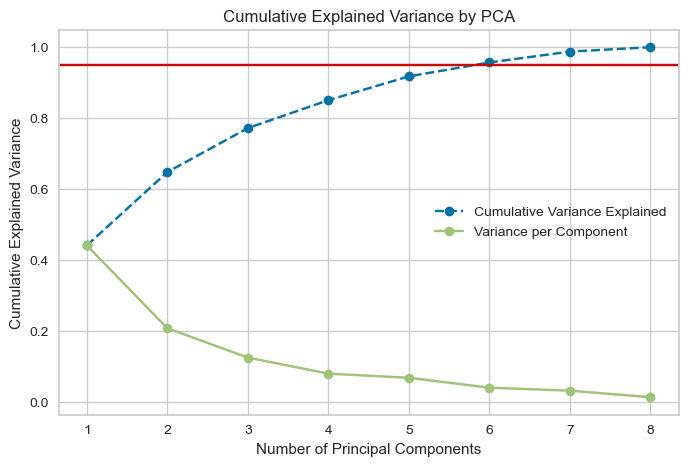

In [37]:
#visualizing the cumulative explained variance by the PCA

cumulative_explained_variance = np.cumsum(explained_variance)

print("\nCumulative Explained Variance Ratios:")
print(cumulative_explained_variance)

# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--',label='Cumulative Variance Explained')
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Variance per Component')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.legend()
plt.show()

From the above graph, it is clear how many Principal components explain 95% of the data. 

To ensure faster computation, and reduce the dimensionality of the data to a more manageable state, while I also try to prevent overfitting within clusters, I will choose to explain 90% of the variance of the data instead of the 95%.

In [38]:
variance_explained_threshold = 0.90
#Calling Principal components with desired variance explained threshold
pca = PCA(variance_explained_threshold)  
pca_comps = pca.fit_transform(housing_data_scaled)  
print('Number of components to explain {:0.0f}% variance is {}'.format(variance_explained_threshold*100, pca.n_components_))

Number of components to explain 90% variance is 5


Based on the above output, 5 PCs are needed to explain 90% of variance. I will now aim to discover the most important features from these components.

In [39]:
most_important_features_pca = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]
most_important_features = housing_data_scaled.columns[most_important_features_pca]

#getting the index of the most important features for each component

print("The most important features are: ",most_important_features.values)

The most important features are:  ['categorieObject' 'Construction_Year' 'Purchase_Price'
 'Construction_Year' 'Number_of_rooms']


Based on the above code, construction year is the most important feature twice. This most likely means the feature is important for 2 of the five Principal Components. This means for those two components, the feature contributes heavily to the 90% of variance explained. Hence, one can infer that this is going to be a fairly important feature in the process of clustering later on.

In [40]:
housing_data_scaled[most_important_features].head(15)

#looking at the first 15 lines of the most important features within the housing data scaled dataframe

,categorieObject,Construction_Year,Purchase_Price,Construction_Year,Number_of_rooms
0,-0.593060,-0.060328,-1.307956,-0.060328,-1.501583
1,-0.593060,0.087579,-0.643111,0.087579,0.569610
2,1.686169,0.827117,-0.087491,0.827117,-1.501583
3,-0.593060,-0.119491,0.686578,-0.119491,0.569610
4,-0.593060,-0.208236,-1.084758,-0.208236,-0.465987
5,-0.593060,0.294650,-0.562380,0.294650,0.569610
6,-0.593060,-1.302751,-0.918547,-1.302751,-0.465987
7,-0.593060,-0.267399,-0.016257,-0.267399,0.569610
8,-0.593060,-1.687311,2.101748,-1.687311,-1.501583
9,-0.593060,0.590465,0.453883,0.590465,-0.465987


Based on the above chart, PCA has been successful. Thanks to this, I can now move on to the main point of this notebook, K-means Clustering.

In [41]:
from sklearn.cluster import KMeans 
from yellowbrick.cluster import KElbowVisualizer

#importing the needed modules for K-means clustering, together with the K-means visualizer

## K-Means Clustering

In [42]:
kmeans = KMeans()

#defining the K-means instance

First I need to find out the optimal number of k/clusters.

c:\Users\buoci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\buoci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\buoci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\buoci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\buoci\anaconda3\Lib\site-packages\sklearn\clust

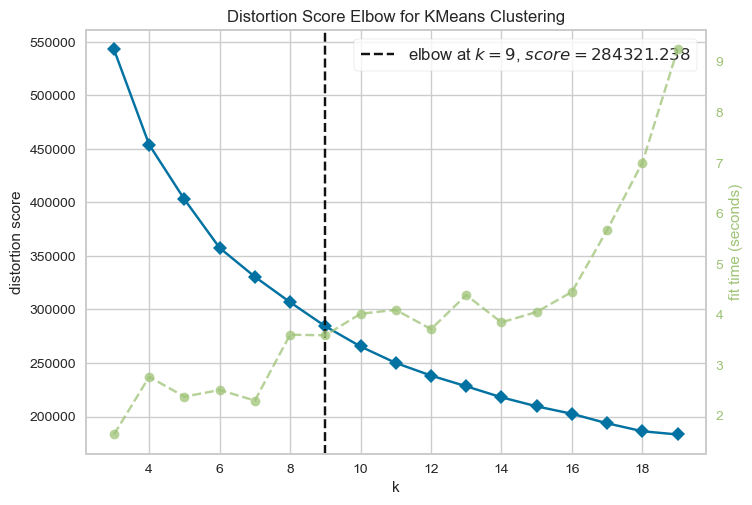

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
visualizer = KElbowVisualizer(kmeans,k=(3,20)) #defining how many clusters I want to evaluate with the k-hyperparameter
visualizer.fit(pca_comps) #fitting the 5 Principal Components
visualizer.show()

Based on the above graph, it is clear that the optimal k-value and therefore the optimal number of clusters is 9. I will now move on to fitting the model with the optimal number of clusters.

In [44]:
optimal_k = 9 #defining the optimal amount of clusters

k_means_optimal = KMeans(n_clusters=optimal_k,random_state=42) #including random state to ensure reproducibility, creating an optimal kmeans instance

I will now fit the optimal k-means model to the pca components, but also to the most important features. I will do this to examine which kind of clustering works better. I will then evaluate the clustering that works best at the end of this notebook.

In [45]:
pca_feature_k_means=k_means_optimal.fit(pca_comps) #fitting the optimal kmeans model to the pca components

cluster_labels = k_means_optimal.labels_ #retrieving the labels

c:\Users\buoci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [46]:
important_features_k_means=k_means_optimal.fit(housing_data_scaled[most_important_features]) #fitting the optimal kmeans model to the most important features
k_means_imp_feat_labels = k_means_optimal.labels_ #retrieving the labels

c:\Users\buoci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Evaluation of Model

After fitting the models, I will now move on to evaluating the models.

For K-means, there are 3 main ways of evaluating the model. These are:
1. Inertia - Inertia measures the within cluster sum of squares. Lower WCSS values indicate tighter clusters.
2. Silhoutte Score - Silhoutte Score measures how similar a given datapoint is to its own cluster, compared to other clusters. This score can range between -1 and 1, with values closer to 1 indicating better-defined clusters.
3. Davies-Bouldin Index - This index measures how similar the clusters are. The similarity in this case is in regards to the size of the clusters and the distance between the clusters. Lower values of this index indicate better clustering.

To evaluate my models, I will only use the latter two methods.

In [47]:
#importing the necessary modules

from sklearn.metrics import silhouette_score,davies_bouldin_score

In [48]:
#calculate silhouette score on kmeans with pca features
silhouette_avg = silhouette_score(pca_comps, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Calculate the Davies-Bouldin score on kmeans with pca features
davies_bouldin_avg = davies_bouldin_score(pca_comps, cluster_labels)
print(f'Davies-Bouldin Score: {davies_bouldin_avg}')

Silhouette Score: 0.302794895002682
Davies-Bouldin Score: 1.104549707522784


In [49]:
#calculating the silhoutte score on kmeans with most important features
silhouette_important_features = silhouette_score(housing_data_scaled[most_important_features],k_means_imp_feat_labels) 

#calculating the DB score on kmeans with most important features
davies_bouldin_important_features = davies_bouldin_score(housing_data_scaled[most_important_features],k_means_imp_feat_labels)

In [50]:
print(f'Silhoutte Score on important features k means: {silhouette_important_features}')
print(f'Davies-Bouldin Score on important features k means: {davies_bouldin_important_features}')

#printing the score

Silhoutte Score on important features k means: 0.31194272830144776
Davies-Bouldin Score on important features k means: 1.0580155510077094


I will evaluate the above scores after displaying 3D visualizations of my resulting clusters.

Now I will plot 3D visualizatiion of clusters with top 3 principal components and 3 most important features. Thanks to this I will be able to visually understand the data better, together with the importance of the features within the clusters. More specifically, it helps me understand why exactly the metrics for the clustering with the most important features are better than the metrics for the PC based clustering.

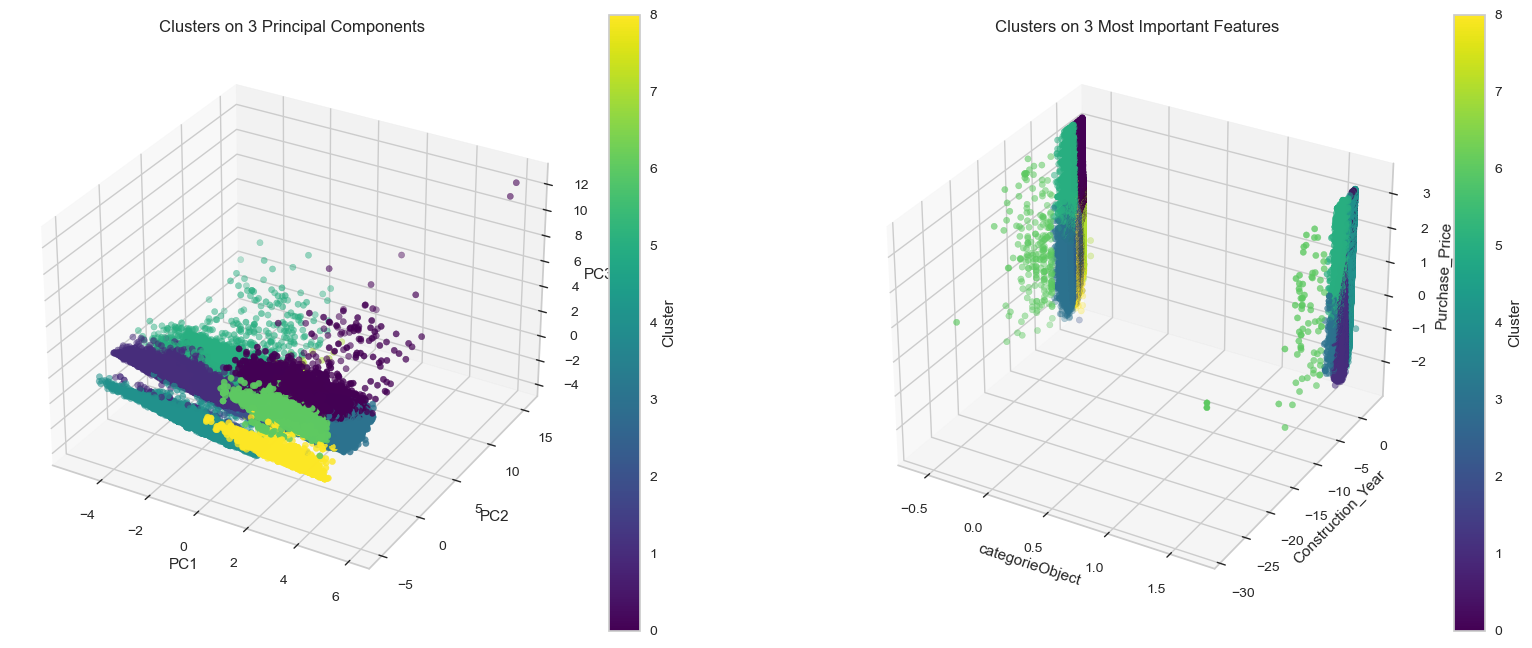

In [51]:
fig,axes = plt.subplots(1,2, figsize=(20,8), subplot_kw={'projection': '3d'})
# Plotting the clusters on the 3 principal components
scatter1 = axes[0].scatter(pca_comps[:, 0], pca_comps[:, 1], pca_comps[:, 2], c=cluster_labels, cmap='viridis')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_zlabel('PC3')
axes[0].set_title('Clusters on 3 Principal Components')

scatter2 = axes[1].scatter(housing_data_scaled[most_important_features[0]], housing_data_scaled[most_important_features[1]], housing_data_scaled[most_important_features[2]], c=k_means_imp_feat_labels, cmap='viridis')
axes[1].set_xlabel(most_important_features[0])
axes[1].set_ylabel(most_important_features[1])
axes[1].set_zlabel(most_important_features[2])
axes[1].set_title('Clusters on 3 Most Important Features')

# Adding the colorbars
color_bar = fig.colorbar(scatter1, ax=axes[0])
color_bar.set_label('Cluster')
color_bar1 = fig.colorbar(scatter2, ax=axes[1])
color_bar1.set_label('Cluster')

plt.show()

The above graph shows together with the metrics above that the clustering based on important features is better than principal-component based clustering. This is because important feature-based clustering has a higher Silhoutte score, while also having a lower Davies-Bouldin score. Based on this alone, the most important feature based clustering will be evaluated further. 

From the above graph on the right, we can already clearly see that cluster 6 contains values low in construction year, and all over the place for purchase price, while containing values closer to 0 for the category object variable. This variable also seems to be very important in clustering, as we can see the clear distinction between clusters being , made on either side of the categorie object variable. To remind the reader, this variable is binary, and distinguishes between an appartment and a house. In this case, house is coded as 0 and apartment as 1.hence it can be inferred based on the colors above that cluster 6 contains mostly house properties, while cluster 1, contains only apartment properties. On the other hand, cluster 0 contains only house properties as this color is not visible on the other side. Same can be said about cluster 8, which can also only be seen on the side closer to 0. Moreover, it is clear that cluster5 contains higher purchase prices, while cluster 1 contains lower purchase prices. Cluster 0 on the other hand contains higher purchase prices.

After choosing the best clustering option as the one with most important features, I will move on to cluster analysis.

### Cluster Analysis

#### 1. Reverting features to original space

To understand the clusters, I first need to revert my features to their original space.

In [52]:
housing_data_clean['Cluster'] = k_means_imp_feat_labels #adding the most important features cluster column to the original dataframe

housing_data_clean.head(15)

,Purchase_Price,categorieObject,Construction_Year,Garden,Number_of_rooms,Energy_label,inside_surface_size,Part1,Cluster
0,139000.0,0,1975.0,1,3,7,62,21,8
1,209000.0,0,1980.0,1,5,6,136,6,2
2,267500.0,1,2005.0,0,3,7,70,-1,4
3,349000.0,0,1973.0,1,5,7,144,6,2
4,162500.0,0,1970.0,1,4,7,68,6,8
5,217500.0,0,1987.0,1,5,7,184,6,2
6,180000.0,0,1933.0,0,4,7,93,6,3
7,275000.0,0,1968.0,1,5,7,139,6,2
8,498000.0,0,1920.0,0,3,7,70,21,5
9,324500.0,0,1997.0,0,4,7,92,6,7


I will now recode the category object, the Part1 or Soortwoning variable, and the energy label variables into the original feature names.

In [53]:
#mapping the category object numbers to variables
categorieObjectmapping = {
    0: 'House',
    1: 'Apartment'
}
#applying the mapping to the housing data dataframe
housing_data_clean['categorieObject'] = housing_data_clean['categorieObject'].map(categorieObjectmapping)
#displaying the dataframe to ensure the operation worked
housing_data_clean.head(25)

,Purchase_Price,categorieObject,Construction_Year,Garden,Number_of_rooms,Energy_label,inside_surface_size,Part1,Cluster
0,139000.0,House,1975.0,1,3,7,62,21,8
1,209000.0,House,1980.0,1,5,6,136,6,2
2,267500.0,Apartment,2005.0,0,3,7,70,-1,4
3,349000.0,House,1973.0,1,5,7,144,6,2
4,162500.0,House,1970.0,1,4,7,68,6,8
5,217500.0,House,1987.0,1,5,7,184,6,2
6,180000.0,House,1933.0,0,4,7,93,6,3
7,275000.0,House,1968.0,1,5,7,139,6,2
8,498000.0,House,1920.0,0,3,7,70,21,5
9,324500.0,House,1997.0,0,4,7,92,6,7


In [54]:
housing_data_clean['categorieObject'] = housing_data_clean['categorieObject'].astype('category')

#changing the data type of categorieObject variable to categorical, for visualisation purposes

Based on the above displayed dataframe, the operation has worked. I will now re-code the energy label variable as well.

Based on the code in the beginning of this notebook, it is clear that the values have been coded as follows: A+ = 1,A++ = 2, A+++ = 3, A++++ = 4, A+++++ = 5, B = 6, C = 7, D = 8, E = 9, F= 10, G = 11.

In [55]:
energy_label_remapping = { #creating the remapping object based on the values mentioned above
    1: 'A+',
    2: 'A++',
    3: 'A+++',
    4: 'A++++',
    5: 'A+++++',
    6: 'B',
    7: 'C',
    8: 'D',
    9: 'E',
    10: 'F',
    11: 'G'
}

#now replacing the numbers with the corresponding energy labels in the dataframe
housing_data_clean['Energy_label'] = housing_data_clean['Energy_label'].map(energy_label_remapping)
#displaying the dataframe to confirm the operation
housing_data_clean.head(25)

,Purchase_Price,categorieObject,Construction_Year,Garden,Number_of_rooms,Energy_label,inside_surface_size,Part1,Cluster
0,139000.0,House,1975.0,1,3,C,62,21,8
1,209000.0,House,1980.0,1,5,B,136,6,2
2,267500.0,Apartment,2005.0,0,3,C,70,-1,4
3,349000.0,House,1973.0,1,5,C,144,6,2
4,162500.0,House,1970.0,1,4,C,68,6,8
5,217500.0,House,1987.0,1,5,C,184,6,2
6,180000.0,House,1933.0,0,4,C,93,6,3
7,275000.0,House,1968.0,1,5,C,139,6,2
8,498000.0,House,1920.0,0,3,C,70,21,5
9,324500.0,House,1997.0,0,4,C,92,6,7


['<{woonboot}>' '<{eengezinswoning}>' nan '<{herenhuis}>' '<{bungalow}>'
 '<{villa}>' '<{maisonnette}> (<{dubbel bovenhuis}>'
 '<{maisonnette}> (<{appartement}>' '<{galerijflat}> (<{appartement}>'
 '<{bovenwoning}> (<{appartement}>' '<{landhuis}>' '<{grachtenpand}>'
 '<{woonboerderij}>' '<{portiekflat}> (<{appartement}>'
 '<{benedenwoning}> (<{appartement}>' '<{portiekwoning}> (<{appartement}>'
 '<{tussenverdieping}> (<{appartement}>'
 '<{bovenwoning}> (<{dubbel bovenhuis}>' '<{penthouse}> (<{appartement}>'
 '<{portiekwoning}> (<{dubbel bovenhuis}>' '<{stacaravan}>'
 '<{benedenwoning}> (<{souterrain}>'
 '<{beneden + bovenwoning}> (<{appartement}>']

Saving the original names for the variable, so it is easier for me to re-code them.

[21  6 -1  9  5 19 12 11  7  3 10  8 20 14  1 15 18  4 13 16 17  2  0] - displaying the codes so it is easier for me to re-code them.

I will also recode these in english for better interpretability when analysing clusters.

In [56]:
Part1_soortwoning_remapping = {
    -1: 'other',
    21: 'houseboat',
    6: 'single-family home',
    9: 'mansion house',
    5: 'bungalow',
    19: 'villa',
    12: 'maisonette double-apartment',
    11: 'maisonette apartment',
    7: 'gallery flat apartment',
    3: 'upstairs apartment',
    10: 'country house',
    8: 'canal house',
    20: 'farmhouse',
    14: 'porch apartment',
    1: 'ground-floor apartment',
    15: 'porch apartment',
    18: 'mezzanine apartment',
    4: 'double upstairs apartment',
    13: 'penthouse apartment',
    16: 'double upper porch apartment',
    17: 'caravan',
    2: 'ground floor and underground floor apartment',
    0: '2-floor apartment'
}

#creating a re-coding map

In [58]:
housing_data_clean['Part1'] = housing_data_clean['Part1'].map(Part1_soortwoning_remapping)

#applying the re-coding map

I will now plot each of the features from the dataset per cluster, to better understand what each cluster contains.

In [57]:
housing_data_clean['categorieObject'] = housing_data_clean['categorieObject'].astype(str)

#converting the category object from categorical to string, in order to be able to perform visualizations with the variable

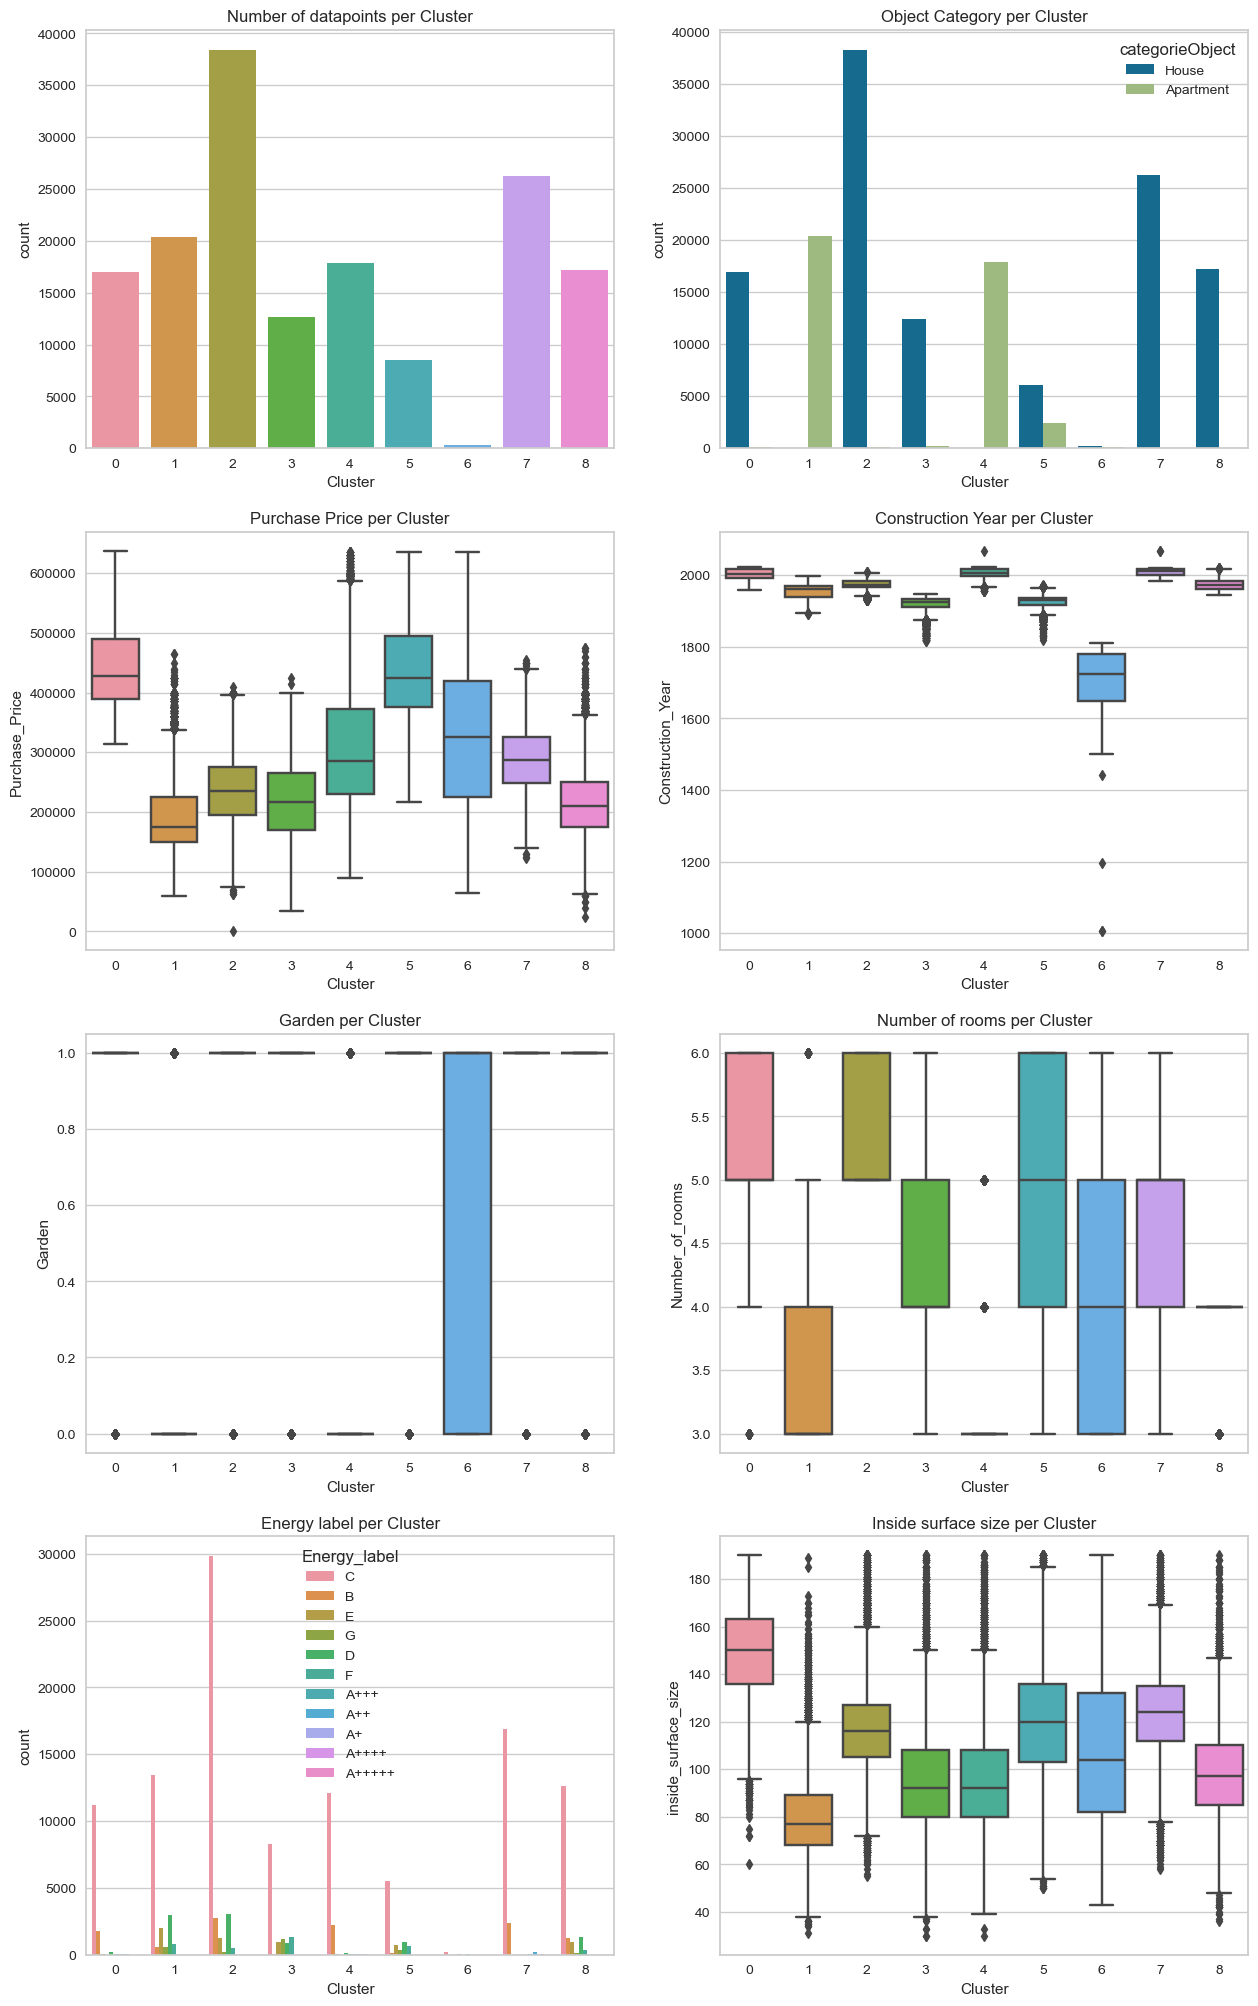

In [91]:
#creating the object for subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 25)) 

# Plotting each of the variables per cluster plus the number of datapoints
axs[0, 0].set_title('Number of datapoints per Cluster')
sns.countplot(x='Cluster', data=housing_data_clean, ax=axs[0, 0])

axs[0, 1].set_title('Object Category per Cluster')
sns.countplot(x='Cluster', hue='categorieObject', data=housing_data_clean, ax=axs[0, 1])

axs[1,0].set_title('Purchase Price per Cluster')
sns.boxplot(x='Cluster',y='Purchase_Price',data=housing_data_clean,ax=axs[1,0])

axs[1,1].set_title('Construction Year per Cluster')
sns.boxplot(x='Cluster',y='Construction_Year',data=housing_data_clean,ax=axs[1,1])

axs[2,0].set_title('Garden per Cluster')
sns.boxplot(x='Cluster',y='Garden',data=housing_data_clean,ax=axs[2,0])

axs[2,1].set_title('Number of rooms per Cluster')
sns.boxplot(x='Cluster',y='Number_of_rooms',data=housing_data_clean,ax=axs[2,1])

axs[3,0].set_title('Energy label per Cluster')
sns.countplot(x='Cluster',hue='Energy_label',data=housing_data_clean,ax=axs[3,0])

axs[3,1].set_title('Inside surface size per Cluster')
sns.boxplot(x='Cluster',y='inside_surface_size',data=housing_data_clean,ax=axs[3,1])

plt.show()

I will now display the SoortWoning(Part1) variable per cluster with only the first 50 000 values. I am doing this to enhance interpretability as with all of the values, the bars displayed on the graph were too small and difficult to distinguish.

<Axes: xlabel='Cluster', ylabel='count'>

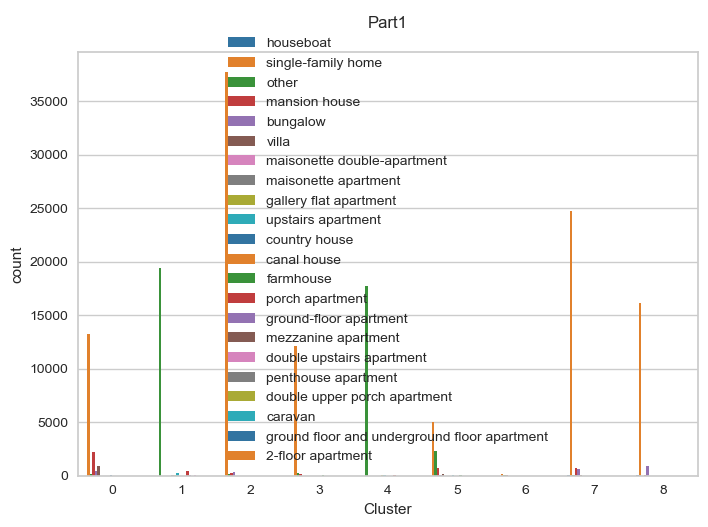

In [87]:
limited_data = housing_data_clean.head(50000) #creating a dataframe to only have the first 50000 values

#setting up the figure axes
sns.countplot(x='Cluster',hue='Part1',data=housing_data_clean,palette='tab10')

#creating this graph for easier interpretation


## Description of Clusters

Cluster 0: This cluster features house properties with a couple of apartment properties present in the cluster as well. The cluster contains properties with the higher end of purchase prices compared to all of the other clusters. This cluster also contains properties from around the years 1950-2000 while featuring no outliers relative to the data. The cluster also includes only properties with a garden. Moreover, the number of rooms within this cluster ranges from 4-6 which makes sense considering it also predominantly features house properties. The energy labels mostly contained in this cluster are C,B and a bit of D. Lastly, the properties within this cluster range in inside surface size from around 95 till 190. This cluster also contains a couple of outliers because of the other features taking precedent over this feature. Within this cluster, the most prevalent category is single family home, with the second biggest category being mansion house. Since this cluster contains the higher-end of purchase prices this makes sense, as one would assume these are the most expensive properties. This cluster also contains villas, and bungalows as well. This fits together with the previous description of the cluster as containing some of the most expensive properties in the entire dataframe.

Cluster 1: This cluster has the 3rd highest datapoint count of all of the created clusters. It also features only apartment properties in contrast with cluster 0 which mostly contains housing properties. This is also reflected in the purchase price, where the average moves around 180 000, much lower than the average of cluster 0. The construction year of the properties within this cluster is also lower than those of cluster 1, but contains a wider range of construction years. The cluster also contains only properties without a garden, which again makes logical sense as the properties are apartments. The number of rooms in this cluster ranges from 3-5, which is in line with these properties being apartments. This cluster contains a wider range of energy labels than the previous cluster, as it includes energy labels C,B,E,D, and F.The inside surface sizes within this cluster are also much smaller on average, however the cluster also contains significantly more outliers compared to the previous cluster. The type of house this cluster mostly contains the other category, which contains the unclassified housetype. What is also contained however are upstairs and porch apartments.

Cluster 2: This cluster entails the most datapoints out of all of the clusters, totalling around 38000 datapoints. This is almost a third of the entire dataframe. The cluster also contains only housing properties and is starting to paint the trend of clustering being heavily based on this feature. The difference with the first cluster however is that these house properties have a significantly lower price than those in cluster 0, ranging from around 80 000 all the way up to 400 000, with the average set at around 230 000. These properties are also a bit older. The fact that these are houses is further confirmed again by these properties also having gardens. The number of rooms within this cluster is stabilized at 5-6 with no outliers, which makes it seem as if this was one of the key features in the creation of this cluster. This cluster again heavily contains energy label C, but also contains, B,D, and E energy label properties. The average inside surface ranges between 105-125, which makes sense for housing properties. For this cluster, the single-family home house type is the most prevalent, together with canal house. Bungalows and mansion houses are also contained in this cluster, however to a very low extent.

Cluster 3: This cluster contains the third least amount of datapoints out of all 9 clusters. In this cluster, the large majority of properties are houses just like the previous cluster, although there is a small amount of apartment properties present as well. The average purchase price within this cluster is similar to the cluster before, with an even wider range of purchase prices present, and very little outliers. The property prices are on the low-middle part of the spectrum relative to other clusters. The construction years here range from late 1800s till the early 1900s, with a lot of outliers closer to the 1800s. This cluster also contains properties with gardens, which is again matching with the fact that the large majority are houses. The majority of properties within this cluster have between 4 and 5 rooms, however this range goes through the whole spectrum from 3 all the way up to 6 rooms. For the first time, in relation to the energy label, some A+++ properties are present, which is surprising considering the construction years. The inside surface size within this cluster is 90 on average, but contains a very wide range with a lot of outliers present. This cluster once again mostly contains the single family home house type, but this time together with ground floor apartment and mezanine apartment. This proves that this feature is not one of the most important features in relation to clustering.

Cluster 4: Contrary with the previous cluster, Cluster 4 contains exclusively apartment properties. These properties are however some of the higher priced properties in the dataframe as can be seen in the purchase price per cluster analysis. This is also reflected in the construction year. as these properties are some of the newest in the dataframe. What is not surprising is that cluster 4 contains only a few properties which have a garden, which makes sense since they are not houses. This cluster also contains almost exclusively properties with 3 rooms, while having outliers having 4 and 5 rooms respectively. For this cluster, the energy labels are only differentiated between B and C, with C once again being the overwhelming majority within the cluster. THe inside surface size of this cluster is almost the same as from cluster 3, which is interesting as the properties in the previous cluster are houses while the properties in this cluster are apartments only. This cluster only contains the category other.

Cluster 5: This cluster contains the second least amount of data out of all of the clusters. It contains both, houses and apartments, with purchase prices around the highest range just like cluster 0. The construction years within this cluster range from the 1900 till around the 1950s with most of these properties having a garden. Early on, this seems like the differentiator within the cluster, grouping together properties with gardens. The number of rooms range is 3-6, encapsulating all the different amounts of rooms available. There is a range of different energy labels in this cluster as well, with energy label C sticking out. This cluster also contains the 3rd highest average inside surface size, with a fairly small range from 105 to around 135, containing very little outliers. The small amount of outliers also signifies that for this particular cluster, the inside surface size played a role in differentiating the properties. In relation to the housing type of this cluster, there are 3 different types of houses. The most prevalent are single-family homes and canal houses, with "other" type properties beign in the second spot, and mansion houses and porch apartments being in the last spot of frequency within this cluster. All of these properties however fit the description of the highest purchase prices out of most of the clusters.

Cluster 6: From the first graph it is apparent that this cluster contains the least amount of data out of all of the clusters, and also by a large amount. It also exclusively contains housing properties, with the purchase price ranging from around 80 000 till around 650 000, containing the widest range of purchase prices out of all of the clusters. This cluster also contains the oldest properties with the newest ones being built a bit after the year 1800 and the oldest ones being from the year 1000. This cluster is also the first one containing properties with and without a garden, signifying that this feature didn't play a role in differentiating this cluster. The average number of rooms per property in this cluster is 4, containing a wide range of different room numbers. The only energy label contained in this cluster is C, signifying that this variable together with mainly the construction year were crucial in the creation of this cluster. The cluster also contains a fairly large range of surface size with no outliers present. In regard to the type of house, because of the fact this cluster contains very little data it is tough to decipher what kinds of houses are contained within the cluster.

Cluster 7: This cluster contains the second highest amount of data out of all of the clusters. Once again, the cluster contains exclusively housing properties, which is the first main differentiating point. The average selling price within this cluster is around 280 000 meaning it is around the middle point of the dataset. The properties here seem to be very new as these are at the top of the construction year column. These properties also contain garden, which is apparent as a trait with housing properties. Most of the properties in this cluster contain between 4 and 5 rooms. The energy labels of the homes here are similar to those contained in cluster 4, with some A+++ properties involved too. Lastly, the average inside surface size in this cluster is around 125 making it the cluster with the second highest inside surface size. It seems that construction year, object category and inside surface size played big roles in the creation of this cluster.

Cluster 8: This cluster contains exclusively house properties, while having the 2nd lowest average purchase price out of all of the clusters. The years in this cluster are a bit below 2000 on average. Moreover, these houses once again have gardens mostly with a few outliers which do not have gardens. The number of rooms in this cluster is almost exclusively 4 with a couple of outliers having 3. With the size of the cluster, one can confidently infer number of rooms was one of the main features the clustering was based on for this cluster. Moreover, the energy label containted within this cluster are mostly C,B,D,E and A++. The inside surface size here is around the middle of the pack with 95 squared meters.

### Central Question : What attributes should a property contain for it to be the most financially viable for a housing company to sell ?

Clustering Related Research questions : 

Sub-Question 1: How does the construction year of properties affect the purchase price of properties within clusters ? 

The construction year of properties does not have as great of an effect on the purchase price within the clusters as one would think. This is apparent when looking at Cluster 6. While this cluster contains the oldest properties from the entire dataset, ranging from construction year +/- 1800 and below, its average purchase price is the third highest. The other clusters however more or less follow the assumption that newer houses will cost more money, but we cannot confirm this for 100% because of cluster 6. The effect of the construction year is therefore not clear.

Sub-Question 2: How does inside surface size influence the purchase price of properties within the created clusters ?

When examining the produced boxplots, it is clear that inside surface size has a large influence on purchase price within the created clusters. The reason for this is that almost all of the clusters are clearly distinguished in terms of surface size.

Sub-Question 3: How do clusters differ in terms of purchase price and number of rooms ? Are these variables dependent ? 

From judging the clusters, and how they are formed, it is clear that there is indeed a dependency between these two variables. The clusters with higher average purchase prices usually also have a higher average number of rooms. Hence it can be inferred that these variables are dependent.

Sub-Question 4: Does selling properties with a garden make more financial sense for a housing company ? 


As having a garden was an important feature within clustering, we can clearly see how this impacts purchase price. However it cannot be concluded that properties with a garden sell for more than properties without a garden. Both of these are a bit all over the place, even though it seems as a fairly important feature in regards to the clusters.

Sub-Question 5: Which k-means clustering model works best ?

From the models tested, the best k-means clustering model worked based on the most important features, not the Principal Components.